In [17]:
from autogen import filter_config, GroupChat, AssistantAgent, UserProxyAgent, GroupChatManager
from config import llm_config
from dotenv import load_dotenv
from autogen.graph_utils import visualize_speaker_transitions_dict

load_dotenv()

llm_config["config_list"] = filter_config(
    config_list=llm_config["config_list"],
    filter_dict={"model": ["gpt-4o-mini"]},
)
config_list = llm_config["config_list"]

In [18]:
task = """Add 1 to the number output by the previous role. If the previous number is 20, output "TERMINATE"."""

In [19]:
# agents configuration
engineer = AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    system_message=task,
    description="I am **ONLY** allowed to speak **immediately** after `Planner`, `Critic` and `Executor`.\nIf the last number mentioned by `Critic` is not a multiple of 5, the next speaker must be `Engineer`.",
)

planner = AssistantAgent(
    name="Planner",
    system_message=task,
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `User` or `Critic`.\nIf the last number mentioned by `Critic` is a multiple of 5, the next speaker must be `Planner`.",
)

executor = AssistantAgent(
    name="Executor",
    system_message=task,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("FINISH"),
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `Engineer`.\nIf the last number mentioned by `Engineer` is a multiple of 3, the next speaker can only be `Executor`.",
)

critic = AssistantAgent(
    name="Critic",
    system_message=task,
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `Engineer`.\nIf the last number mentioned by `Engineer` is not a multiple of 3, the next speaker can only be `Critic`.",
)

user_proxy = UserProxyAgent(
    name="User",
    system_message=task,
    code_execution_config=False,
    human_input_mode="NEVER",
    llm_config=False,
    description="Never select me as a speaker.",
)

In [20]:
graph_dict = {}
graph_dict[user_proxy] = [planner]
graph_dict[planner] = [engineer]
graph_dict[engineer] = [critic, executor]
graph_dict[critic] = [engineer, planner]
graph_dict[executor] = [engineer]
graph_dict

{<autogen.agentchat.user_proxy_agent.UserProxyAgent at 0x7fbaae244680>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedcecc0>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedcecc0>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaae244440>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaae244440>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedce390>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>]}

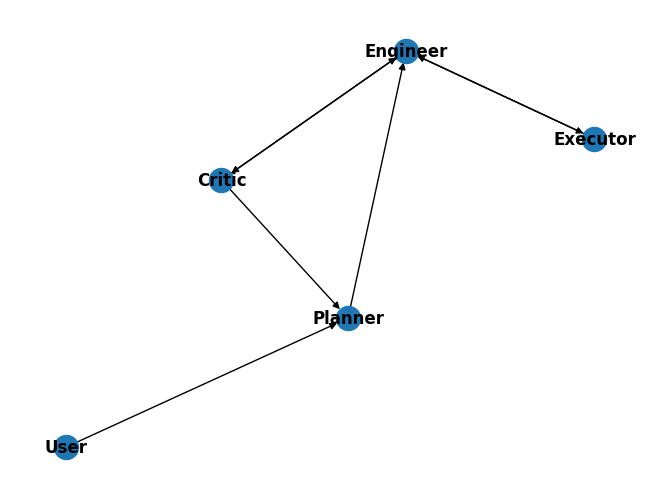

In [24]:
agents = [user_proxy, engineer, planner, executor, critic]
visualize_speaker_transitions_dict(graph_dict, agents)

In [15]:
agents = [user_proxy, engineer, planner, executor, critic]

# create the groupchat
group_chat = GroupChat(agents=agents, messages=[], max_round=25, allowed_or_disallowed_speaker_transitions=graph_dict, allow_repeat_speaker=None, speaker_transitions_type="allowed")

# create the manager
manager = GroupChatManager(
    groupchat=group_chat,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,
)

In [16]:
# initiate the task
user_proxy.initiate_chat(manager, message="1", clear_history=True)

User (to chat_manager):

1

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

2

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

3

--------------------------------------------------------------------------------

Next speaker: Executor

Executor (to chat_manager):

4

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

5

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

6

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

7

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

8

----------------

ChatResult(chat_id=None, chat_history=[{'content': '1', 'role': 'assistant', 'name': 'User'}, {'content': '2', 'name': 'Planner', 'role': 'user'}, {'content': '3', 'name': 'Engineer', 'role': 'user'}, {'content': '4', 'name': 'Executor', 'role': 'user'}, {'content': '5', 'name': 'Engineer', 'role': 'user'}, {'content': '6', 'name': 'Critic', 'role': 'user'}, {'content': '7', 'name': 'Engineer', 'role': 'user'}, {'content': '8', 'name': 'Critic', 'role': 'user'}, {'content': '9', 'name': 'Planner', 'role': 'user'}, {'content': '10', 'name': 'Engineer', 'role': 'user'}, {'content': '11', 'name': 'Critic', 'role': 'user'}, {'content': '12', 'name': 'Planner', 'role': 'user'}, {'content': '13', 'name': 'Engineer', 'role': 'user'}, {'content': '14', 'name': 'Executor', 'role': 'user'}, {'content': '15', 'name': 'Engineer', 'role': 'user'}, {'content': '16', 'name': 'Executor', 'role': 'user'}, {'content': '17', 'name': 'Engineer', 'role': 'user'}, {'content': '18', 'name': 'Executor', 'role